In [1]:
#Installing Required Dependencies
!pip install brian2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from brian2 import *

#Setting Neuron Types and Current
neuron_type = 'type2'    #Current types: type1c, type1t, type12, type21, type2, type2o
Ipulse = 250*pA           #Choose Current Amplitude

In [3]:
C = 12*pF
eh = -43*mV
ek = -77*mV  
el = -65*mV
ena = 55*mV 
nf = 0.85  #proportion of n vs p kinetics
zss = 0.5  #steady state inactivation of glt
temp = 22.  #temperature in degree celcius
q10 = 3. ** ((temp - 22) / 10.)
frac = 0.0
qt = 4.5 ** ((temp - 33.) / 10.)

In [4]:
# Maximal conductances of different cell types in nS
maximal_conductances = dict(
type1c=(1000, 150, 0, 0, 0.5, 0, 2),
type1t=(1000, 80, 0, 65, 0.5, 0, 2),
type12=(1000, 150, 20, 0, 2, 0, 2),
type21=(1000, 150, 35, 0, 3.5, 0, 2),
type2=(1000, 150, 200, 0, 20, 0, 2),
)
gnabar, gkhtbar, gkltbar, gkabar, ghbar, gbarno, gl = [x * nS for x in maximal_conductances[neuron_type]]

In [5]:
# Classical Na channel
eqs_na = """
ina = gnabar*m**3*h*(ena-v) : amp
dm/dt=q10*(minf-m)/mtau : 1
dh/dt=q10*(hinf-h)/htau : 1 
minf = 1./(1+exp(-(vu + 38.) / 7.)) : 1
hinf = 1./(1+exp((vu + 65.) / 6.)) : 1
mtau =  ((10. / (5*exp((vu+60.) / 18.) + 36.*exp(-(vu+60.) / 25.))) + 0.04)*ms : second
htau =  ((100. / (7*exp((vu+60.) / 11.) + 10.*exp(-(vu+60.) / 25.))) + 0.6)*ms : second
"""

# KHT channel (delayed-rectifier K+)
eqs_kht = """
ikht = gkhtbar*(nf*n**2 + (1-nf)*p)*(ek-v) : amp
dn/dt=q10*(ninf-n)/ntau : 1
dp/dt=q10*(pinf-p)/ptau : 1
ninf =   (1 + exp(-(vu + 15) / 5.))**-0.5 : 1
pinf =  1. / (1 + exp(-(vu + 23) / 6.)) : 1
ntau =  ((100. / (11*exp((vu+60) / 24.) + 21*exp(-(vu+60) / 23.))) + 0.7)*ms : second
ptau = ((100. / (4*exp((vu+60) / 32.) + 5*exp(-(vu+60) / 22.))) + 5)*ms : second
"""

# Ih channel (subthreshold adaptive, non-inactivating)
eqs_ih = """
ih = ghbar*r*(eh-v) : amp
dr/dt=q10*(rinf-r)/rtau : 1
rinf = 1. / (1+exp((vu + 76.) / 7.)) : 1
rtau = ((100000. / (237.*exp((vu+60.) / 12.) + 17.*exp(-(vu+60.) / 14.))) + 25.)*ms : second
"""

# KLT channel (low threshold K+)
eqs_klt = """
iklt = gkltbar*w**4*z*(ek-v) : amp
dw/dt=q10*(winf-w)/wtau : 1
dz/dt=q10*(zinf-z)/ztau : 1
winf = (1. / (1 + exp(-(vu + 48.) / 6.)))**0.25 : 1
zinf = zss + ((1.-zss) / (1 + exp((vu + 71.) / 10.))) : 1
wtau = ((100. / (6.*exp((vu+60.) / 6.) + 16.*exp(-(vu+60.) / 45.))) + 1.5)*ms : second
ztau = ((1000. / (exp((vu+60.) / 20.) + exp(-(vu+60.) / 8.))) + 50)*ms : second
"""

# Ka channel (transient K+)
eqs_ka = """
ika = gkabar*a**4*b*c*(ek-v): amp
da/dt=q10*(ainf-a)/atau : 1
db/dt=q10*(binf-b)/btau : 1
dc/dt=q10*(cinf-c)/ctau : 1
ainf = (1. / (1 + exp(-(vu + 31) / 6.)))**0.25 : 1
binf = 1. / (1 + exp((vu + 66) / 7.))**0.5 : 1
cinf = 1. / (1 + exp((vu + 66) / 7.))**0.5 : 1
atau =  ((100. / (7*exp((vu+60) / 14.) + 29*exp(-(vu+60) / 24.))) + 0.1)*ms : second
btau =  ((1000. / (14*exp((vu+60) / 27.) + 29*exp(-(vu+60) / 24.))) + 1)*ms : second
ctau = ((90. / (1 + exp((-66-vu) / 17.))) + 10)*ms : second
"""

# Leak
eqs_leak = """
ileak = gl*(el-v) : amp
"""

eqs_hcno = """
ihcno = gbarno*(h1*frac + h2*(1-frac))*(eh-v) : amp
dh1/dt=(hinfno-h1)/tau1 : 1
dh2/dt=(hinfno-h2)/tau2 : 1
hinfno = 1./(1+exp((vu+66.)/7.)) : 1
tau1 = bet1/(qt*0.008*(1+alp1))*ms : second
tau2 = bet2/(qt*0.0029*(1+alp2))*ms : second
alp1 = exp(1e-3*3*(vu+50)*9.648e4/(8.315*(273.16+temp))) : 1
bet1 = exp(1e-3*3*0.3*(vu+50)*9.648e4/(8.315*(273.16+temp))) : 1
alp2 = exp(1e-3*3*(vu+84)*9.648e4/(8.315*(273.16+temp))) : 1
bet2 = exp(1e-3*3*0.6*(vu+84)*9.648e4/(8.315*(273.16+temp))) : 1
"""

In [6]:
eqs = """
dv/dt = (ileak + ina + ikht + iklt + ika + ih + ihcno + I)/C : volt
vu = v/mV : 1  # unitless v
I : amp
"""
eqs += eqs_leak + eqs_ka + eqs_na + eqs_ih + eqs_klt + eqs_kht + eqs_hcno

neuron = NeuronGroup(1, eqs, method='exponential_euler')
neuron.v = el

Starting simulation at t=0. s for a duration of 50. ms
50. ms (100%) simulated in < 1s
Starting simulation at t=50. ms for a duration of 100. ms
100. ms (100%) simulated in < 1s


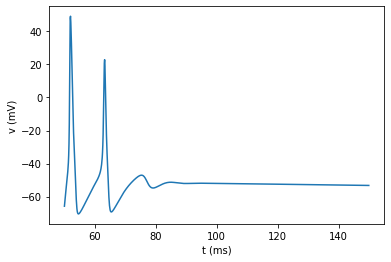

In [7]:
run(50*ms, report='text')  # Go to rest

M = StateMonitor(neuron, 'v', record=0)
neuron.I = Ipulse

run(100*ms, report='text')

plot(M.t / ms, M[0].v / mV)
xlabel('t (ms)')
ylabel('v (mV)')
show()